<a href="https://colab.research.google.com/github/Manuelstv/financas-quantitativas/blob/main/fatos_estilizados_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import seaborn as sns
import math
import random

import scipy.signal
from scipy import stats
from scipy.stats import norm,t, kurtosis, moment
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs

plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams.update({'font.size': 22})

import warnings
warnings.filterwarnings('ignore')

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=67bfbcc95af5439f2da181e41a4f20fc1f7c8d7589b9010791126973f76e9468
  Stored in directory: /tmp/pip-ephem-wheel-cache-t7vszrmu/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


# Download dos dados

In [ ]:
start = "2020-09-16"
end = "2020-09-23"
ativo = yf.download("USDBRL=X", start = start, end = end, interval ='1m')[["Adj Close", "Volume"]]
ativo.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


#Cálculo do log retorno

In [ ]:
#log price-return
ativo["log retorno"] = np.log(ativo["Adj Close"].shift(-1)) - np.log(ativo["Adj Close"])
ativo.head()

,Adj Close,Volume,log retorno
Datetime,,,
2020-09-16 01:19:00+01:00,5.2758,0,0.000000
2020-09-16 01:20:00+01:00,5.2758,0,0.000000
2020-09-16 02:21:00+01:00,5.2758,0,0.000000
2020-09-16 02:47:00+01:00,5.2758,0,0.000000
2020-09-16 03:37:00+01:00,5.2758,0,0.000493


#Normalização do log retorno

In [ ]:
#media do log-price return
media_log = ativo["log retorno"].mean()
#media dos quadrados do log-price return
media_quadrados_log = (ativo["log retorno"]**2).mean()

#retorno normalizado
ativo["retorno normalizado"] = (ativo["log retorno"] - media_log) / (np.sqrt(media_quadrados_log - media_log**2))
ativo.head()

,Adj Close,Volume,log retorno,retorno normalizado
Datetime,,,,
2020-09-16 01:19:00+01:00,5.2758,0,0.000000,-0.020484
2020-09-16 01:20:00+01:00,5.2758,0,0.000000,-0.020484
2020-09-16 02:21:00+01:00,5.2758,0,0.000000,-0.020484
2020-09-16 02:47:00+01:00,5.2758,0,0.000000,-0.020484
2020-09-16 03:37:00+01:00,5.2758,0,0.000493,0.747890


#Estimando densidade de probabilidade pelo método de estimativa de densidade kernel

In [ ]:
ativo = ativo.dropna()
lista_retorno_normalizado = list(ativo["retorno normalizado"])
cols = ativo.shape[0]

#variancia (segundo momento central)
sigma = ativo["retorno normalizado"].var()
#largura de banda (window size)
h1 = 1.06
h2 = 0.2
h = h1*(sigma**2)*(cols**(-h2))

kde = sm.nonparametric.KDEUnivariate(lista_retorno_normalizado)
#Não consigo calcular o .cdf e o .evaluate quando o kernel é epanechnickov
#kde.fit(kernel ="epa",fft= False, bw = h )
kde.fit(bw =h)

#Plot do ccdf

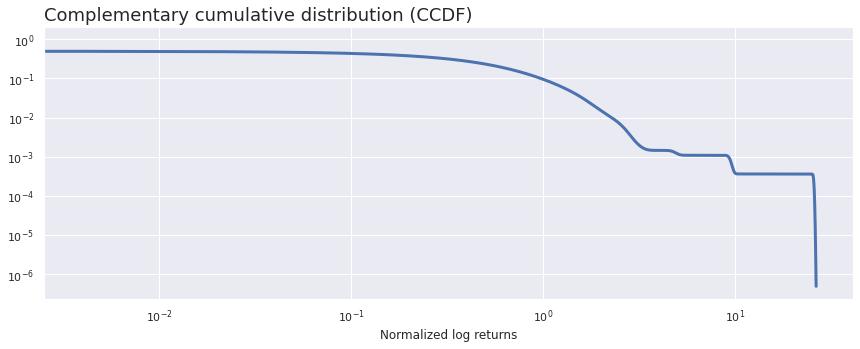

In [ ]:
sns.set()

fig, ax = plt.subplots(figsize=(14.5,5))
ax.set_title("Complementary cumulative distribution (CCDF) ", loc="left", fontsize=18)
ax.set_xlabel("Normalized log returns")
ax.plot(kde.support, 1 - kde.cdf, lw=3)
plt.xscale('log')
plt.yscale('log') 
ax=ax

#plot densidade de probabilidade pelo método

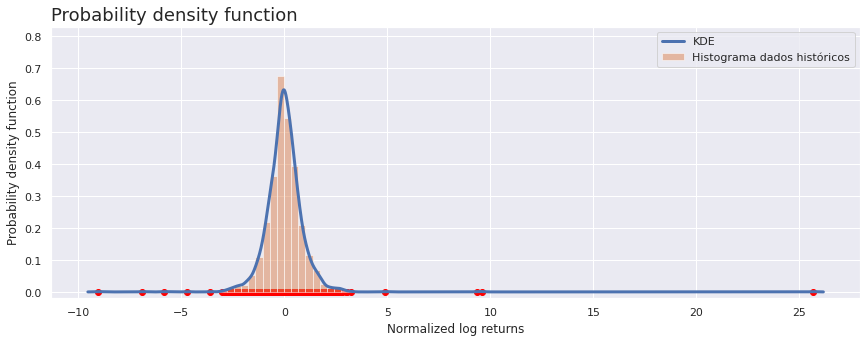

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))

ax.plot(kde.support, kde.density, lw=3, label='KDE')
ax.set_xlabel("Normalized log returns")
ax.set_ylabel("Probability density function")
ax.set_title("Probability density function", loc="left", fontsize=18)
ax.scatter(lista_retorno_normalizado, np.zeros_like(lista_retorno_normalizado), marker='o', color='red')
ax.hist(lista_retorno_normalizado, bins=100, label='Histograma dados históricos', density=True, alpha=0.5)
plt.legend()

ax.set_ylim([-0.02,0.83])
ax=ax

#estimando densidade de probabilidade através das curvas normais e t de student

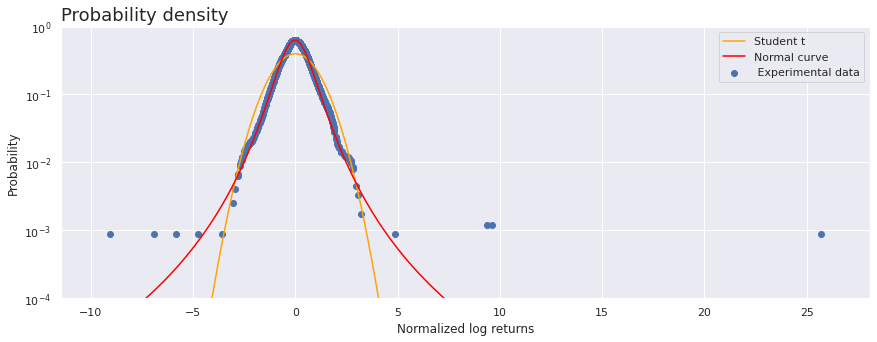

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))

ax.scatter(lista_retorno_normalizado, kde.evaluate(lista_retorno_normalizado), label =" Experimental data")
ax3 = sns.distplot(lista_retorno_normalizado, fit=norm, kde=False, hist = False, fit_kws={"color":"orange"}, label = "Student t")
ax3 = sns.distplot(lista_retorno_normalizado, fit=t, kde=False, hist = False, fit_kws={"color":"red"}, label = "Normal curve")

ax.set_yscale('log')
ax.set_ylim([10**-4,1])
ax.set_xlabel("Normalized log returns")
ax.set_ylabel("Probability")
ax.set_title("Probability density", loc="left", fontsize=18)
ax.legend()
ax=ax

#Verificando se a variância da série converge

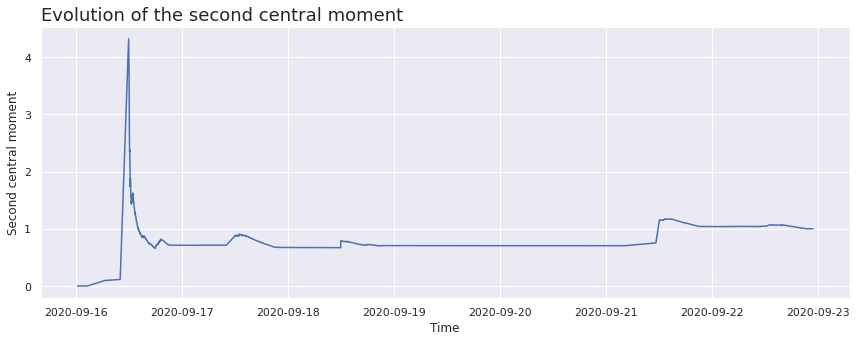

In [ ]:
array_variancia = []
ativo["variancia"]=0

for i in range(0,cols):
  #array_variancia.append(np.var(ativo.iloc[0:i]["retorno normalizado"]))
  ativo["variancia"].iloc[i] = np.var(ativo.iloc[0:i]["retorno normalizado"])

fig, ax = plt.subplots(figsize=(14.5,5))
ax.plot(ativo["variancia"])
ax.set_xlabel("Time")
ax.set_ylabel("Second central moment")
ax.set_title("Evolution of the second central moment", loc="left", fontsize=18)
ax = ax

#Bootstrap samples ??????

In [ ]:
com ='''p=[]

for i in range(0, 10):
  df = ativo[['Adj Close']].sample(n=100).sort_index()
  df["log retorno"] = np.log(df["Adj Close"].shift(-1)) - np.log(df["Adj Close"])
  df = df.dropna()
  #array_log_retorno = df["log retorno"].to_numpy()
  #p.append(kurtosis(array_log_retorno))
  media_log = df["log retorno"].mean()
  media_quadrados_log = (df["log retorno"]**2).mean()
  df["retorno normalizado"] = (df["log retorno"] - media_log) / (np.sqrt(media_quadrados_log - media_log**2))

  array_variancia = []
  array_time = []

  for k in range(0,df.size):
    array_variancia.append(np.var(ativo.iloc[0:k]["retorno normalizado"]))

  #array_time = list(df.index[0:k])
  plt.plot(array_variancia)'''

In [ ]:
com ='''from sklearn.utils import resample
for i in range(0,100):
  array_variancia=[]
  boot = resample(ativo, replace=True, n_samples=100)
  for i in range(0,boot.size):
    array_variancia.append(np.var(ativo.iloc[0:i]["retorno normalizado"]))
    array_tempo.append()

  plt.plot(array_variancia)'''

#Calculando as autocorrelações:

#Correlação dos log-retornos

In [ ]:
from scipy.fft import fft, ifft

N=len(lista_retorno_normalizado)
omega = 0.2
dt = 2*np.pi/omega/128
time = np.arange(N)*dt

densidade_espectral = scipy.fft(lista_retorno_normalizado)*np.conj(scipy.fft(lista_retorno_normalizado))/N
autocorr = scipy.ifft(densidade_espectral).real

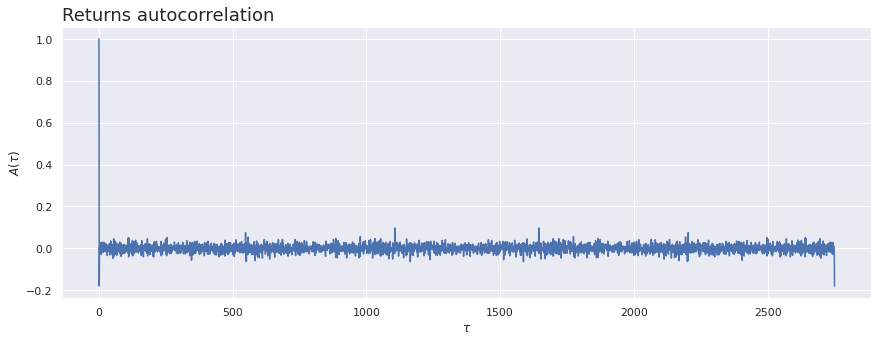

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))
ax.plot(autocorr)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$A(\tau)$')
ax.set_title("Returns autocorrelation", loc="left", fontsize=18)
#ax.set_xlim(-10,)
#ax.set_xscale('log')
ax = ax

#COrrelaçao dos log-retornos ^2

In [ ]:
ativo["log retorno quadrado"] = ativo["log retorno"]**2
#media do log-price return
media_log = ativo["log retorno quadrado"].mean()
#media dos quadrados do log-price return
media_quadrados_log = (ativo["log retorno quadrado"]**2).mean()
#retorno normalizado
ativo["retorno quadrado normalizado"] = (ativo["log retorno quadrado"] - media_log) / (np.sqrt(media_quadrados_log - media_log**2))
#ativo.head()

In [ ]:
lista_retorno_quadrado_normalizado = list(ativo["retorno quadrado normalizado"])
N=len(lista_retorno_quadrado_normalizado)

omega = 0.2
dt = 2*np.pi/omega/128
time = np.arange(N)*dt

densidade_espectral = scipy.fft(lista_retorno_quadrado_normalizado)*np.conj(scipy.fft(lista_retorno_quadrado_normalizado))/N
autocorr = scipy.ifft(densidade_espectral).real

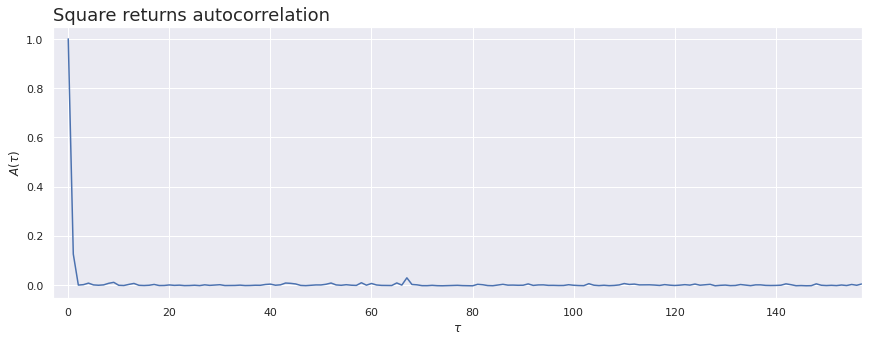

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))
ax.plot(autocorr)
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$A(\tau)$')
ax.set_title("Square returns autocorrelation", loc="left", fontsize=18)
ax.set_xlim(-3, 5*2*np.pi/omega)
#ax.set_xscale('log')
ax = ax

In [ ]:
#F(f*g) = conj(F(f))*F(g) => f*g  = f^(-1) (conj(F(f))*F(g))
signal.fftconvolve(, sig[::-1], mode='full')